[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing files: 100%|████████████████████████████████████████████████████████████████| 39/39 [02:57<00:00,  4.56s/it]



Error Category Analysis:
Shared Errors:
  Count: 51
  Mean Δ log-prob: 1.0275
  Std Δ log-prob: 1.5040

Disappeared Errors:
  Count: 11
  Mean Δ log-prob: -0.6213
  Std Δ log-prob: 3.9971

New Errors:
  Count: 8
  Mean Δ log-prob: 1.3018
  Std Δ log-prob: 2.2274



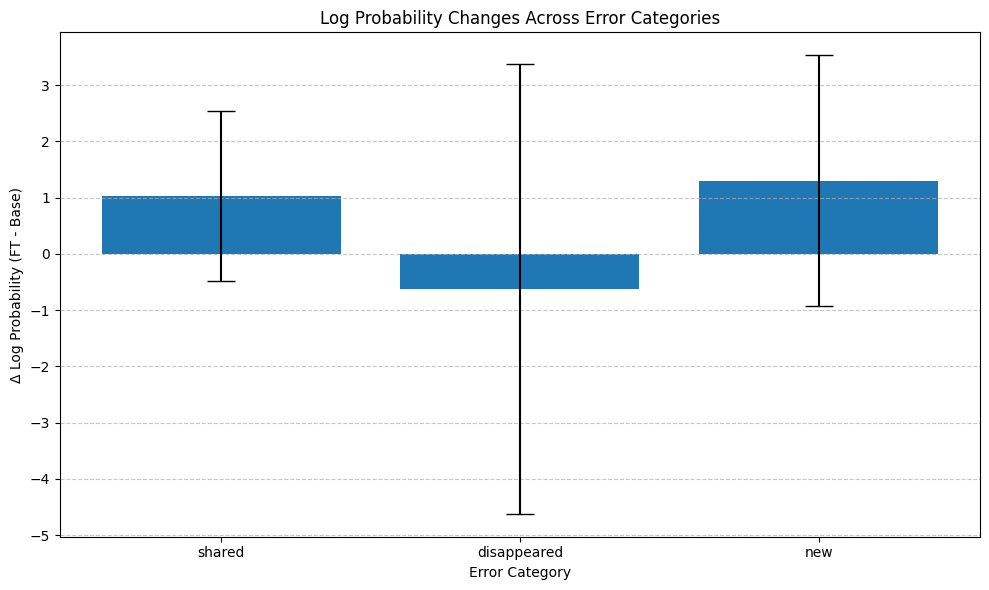

In [3]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import difflib
import nltk
from nltk.corpus import stopwords
import numpy as np

nltk.download('stopwords')

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

stop_words = set(stopwords.words('english'))
supported_formats = (".mp3", ".wav")

# Load models
base_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base.en")
base_model.eval()

model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def transcribe_model(audio_path, model, processor):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    features = processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    if hasattr(model.generation_config, "forced_decoder_ids"):
        model.generation_config.forced_decoder_ids = None

    with torch.no_grad():
        outputs = model.generate(
            input_features,
            output_scores=True,
            return_dict_in_generate=True,
        )

    predicted_ids = outputs.sequences
    transcription = processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    # Calculate log probabilities for each token
    log_probs = []
    for step, score in enumerate(outputs.scores):
        log_prob = torch.nn.functional.log_softmax(score, dim=-1)
        token_id = predicted_ids[0][step + 1]  # Skip the first token (sos)
        log_probs.append(log_prob[0, token_id].item())

    return transcription, log_probs

def get_word_alignments(ground_truth, hypothesis):
    gt_words = ground_truth.split()
    hyp_words = hypothesis.split()
    matcher = difflib.SequenceMatcher(None, gt_words, hyp_words)
    
    alignments = []
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            for i, j in zip(range(i1, i2), range(j1, j2)):
                alignments.append( (i, j, True) )
        else:
            for i in range(i1, i2):
                alignments.append( (i, None, False) )
            for j in range(j1, j2):
                alignments.append( (None, j, False) )
    return alignments

def categorize_errors(gt_words, base_words, ft_words):
    base_align = get_word_alignments(' '.join(gt_words), ' '.join(base_words))
    ft_align = get_word_alignments(' '.join(gt_words), ' '.join(ft_words))
    
    error_categories = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    for i in range(len(gt_words)):
        base_correct = any(a[0] == i and a[2] for a in base_align)
        ft_correct = any(a[0] == i and a[2] for a in ft_align)
        
        if not base_correct and not ft_correct:
            error_categories['shared'].append(i)
        elif not base_correct and ft_correct:
            error_categories['disappeared'].append(i)
        elif base_correct and not ft_correct:
            error_categories['new'].append(i)
    
    return error_categories

def calculate_deltas(error_categories, base_log_probs, ft_log_probs):
    deltas = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    # Helper to find word log probs
    def get_log_probs(word_idx, log_probs):
        if word_idx < len(log_probs):
            return log_probs[word_idx]
        return 0
    
    for idx in error_categories['shared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['shared'].append(ft_log - base_log)
    
    for idx in error_categories['disappeared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['disappeared'].append(ft_log - base_log)
    
    for idx in error_categories['new']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['new'].append(ft_log - base_log)
    
    return deltas

def transcribe_with_both_models(audio_dir):
    results = []
    error_deltas = defaultdict(list)
    
    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]
    
    for filename in tqdm(files, desc="Processing files"):
        file_path = os.path.join(audio_dir, filename)
        txt_path = os.path.join(audio_dir, os.path.splitext(filename)[0] + ".txt")
        
        with open(txt_path, 'r') as f:
            ground_truth = f.read().strip()
        
        # Transcribe with both models
        base_text, base_log_probs = transcribe_model(file_path, base_model, base_processor)
        ft_text, ft_log_probs = transcribe_model(file_path, ft_model, ft_processor)
        
        # Transform texts
        gt_processed = transforms(ground_truth)
        base_processed = transforms(base_text)
        ft_processed = transforms(ft_text)
        
        gt_words = gt_processed[0] if isinstance(gt_processed, list) else []
        base_words = base_processed[0] if isinstance(base_processed, list) else []
        ft_words = ft_processed[0] if isinstance(ft_processed, list) else []
        
        # Categorize errors
        error_cats = categorize_errors(gt_words, base_words, ft_words)
        
        # Calculate deltas
        deltas = calculate_deltas(error_cats, base_log_probs, ft_log_probs)
        
        # Aggregate deltas
        for k in deltas:
            error_deltas[k].extend(deltas[k])
        
        # Store results
        results.append({
            'filename': filename,
            'base_text': base_text,
            'ft_text': ft_text,
            'ground_truth': ground_truth,
            'errors': error_cats
        })
    
    return results, error_deltas

def analyze_deltas(error_deltas):
    analysis = {}
    for category, deltas in error_deltas.items():
        if not deltas:
            analysis[category] = {'mean': 0, 'std': 0}
            continue
        analysis[category] = {
            'mean': np.mean(deltas),
            'std': np.std(deltas),
            'count': len(deltas)
        }
    return analysis

# Run analysis
audio_dir = "dataset/a/"
results, error_deltas = transcribe_with_both_models(audio_dir)
analysis = analyze_deltas(error_deltas)

# Print results
print("\nError Category Analysis:")
for category, stats in analysis.items():
    print(f"{category.capitalize()} Errors:")
    print(f"  Count: {stats['count']}")
    print(f"  Mean Δ log-prob: {stats['mean']:.4f}")
    print(f"  Std Δ log-prob: {stats['std']:.4f}\n")

# Visualization
categories = ['shared', 'disappeared', 'new']
means = [analysis[cat]['mean'] for cat in categories]
stds = [analysis[cat]['std'] for cat in categories]

plt.figure(figsize=(10, 6))
plt.bar(categories, means, yerr=stds, capsize=10)
plt.xlabel('Error Category')
plt.ylabel('Δ Log Probability (FT - Base)')
plt.title('Log Probability Changes Across Error Categories')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('delta_log_probs.png')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing files: 100%|████████████████████████████████████████████████████████████████| 51/51 [03:09<00:00,  3.71s/it]



Error Category Analysis:
Shared Errors:
  Count: 60
  Mean Δ log-prob: 0.4727
  Std Δ log-prob: 1.8508

Disappeared Errors:
  Count: 1
  Mean Δ log-prob: 0.5979
  Std Δ log-prob: 0.0000

New Errors:
  Count: 9
  Mean Δ log-prob: 1.1429
  Std Δ log-prob: 4.4343



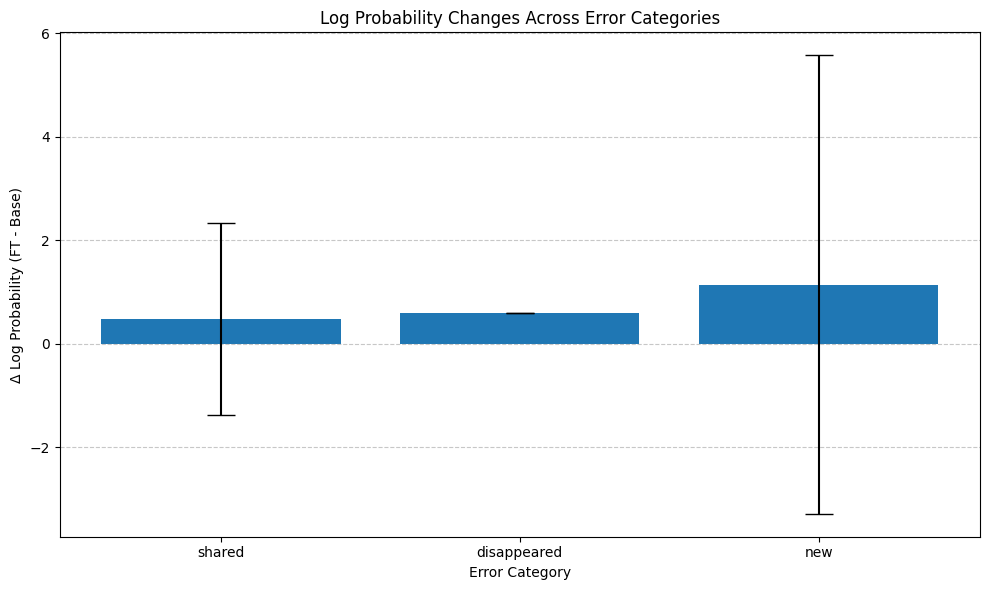

In [4]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import difflib
import nltk
from nltk.corpus import stopwords
import numpy as np

nltk.download('stopwords')

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

stop_words = set(stopwords.words('english'))
supported_formats = (".mp3", ".wav")

# Load models
base_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base.en")
base_model.eval()

model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def transcribe_model(audio_path, model, processor):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    features = processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    if hasattr(model.generation_config, "forced_decoder_ids"):
        model.generation_config.forced_decoder_ids = None

    with torch.no_grad():
        outputs = model.generate(
            input_features,
            output_scores=True,
            return_dict_in_generate=True,
        )

    predicted_ids = outputs.sequences
    transcription = processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    # Calculate log probabilities for each token
    log_probs = []
    for step, score in enumerate(outputs.scores):
        log_prob = torch.nn.functional.log_softmax(score, dim=-1)
        token_id = predicted_ids[0][step + 1]  # Skip the first token (sos)
        log_probs.append(log_prob[0, token_id].item())

    return transcription, log_probs

def get_word_alignments(ground_truth, hypothesis):
    gt_words = ground_truth.split()
    hyp_words = hypothesis.split()
    matcher = difflib.SequenceMatcher(None, gt_words, hyp_words)
    
    alignments = []
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            for i, j in zip(range(i1, i2), range(j1, j2)):
                alignments.append( (i, j, True) )
        else:
            for i in range(i1, i2):
                alignments.append( (i, None, False) )
            for j in range(j1, j2):
                alignments.append( (None, j, False) )
    return alignments

def categorize_errors(gt_words, base_words, ft_words):
    base_align = get_word_alignments(' '.join(gt_words), ' '.join(base_words))
    ft_align = get_word_alignments(' '.join(gt_words), ' '.join(ft_words))
    
    error_categories = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    for i in range(len(gt_words)):
        base_correct = any(a[0] == i and a[2] for a in base_align)
        ft_correct = any(a[0] == i and a[2] for a in ft_align)
        
        if not base_correct and not ft_correct:
            error_categories['shared'].append(i)
        elif not base_correct and ft_correct:
            error_categories['disappeared'].append(i)
        elif base_correct and not ft_correct:
            error_categories['new'].append(i)
    
    return error_categories

def calculate_deltas(error_categories, base_log_probs, ft_log_probs):
    deltas = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    # Helper to find word log probs
    def get_log_probs(word_idx, log_probs):
        if word_idx < len(log_probs):
            return log_probs[word_idx]
        return 0
    
    for idx in error_categories['shared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['shared'].append(ft_log - base_log)
    
    for idx in error_categories['disappeared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['disappeared'].append(ft_log - base_log)
    
    for idx in error_categories['new']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['new'].append(ft_log - base_log)
    
    return deltas

def transcribe_with_both_models(audio_dir):
    results = []
    error_deltas = defaultdict(list)
    
    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]
    
    for filename in tqdm(files, desc="Processing files"):
        file_path = os.path.join(audio_dir, filename)
        txt_path = os.path.join(audio_dir, os.path.splitext(filename)[0] + ".txt")
        
        with open(txt_path, 'r') as f:
            ground_truth = f.read().strip()
        
        # Transcribe with both models
        base_text, base_log_probs = transcribe_model(file_path, base_model, base_processor)
        ft_text, ft_log_probs = transcribe_model(file_path, ft_model, ft_processor)
        
        # Transform texts
        gt_processed = transforms(ground_truth)
        base_processed = transforms(base_text)
        ft_processed = transforms(ft_text)
        
        gt_words = gt_processed[0] if isinstance(gt_processed, list) else []
        base_words = base_processed[0] if isinstance(base_processed, list) else []
        ft_words = ft_processed[0] if isinstance(ft_processed, list) else []
        
        # Categorize errors
        error_cats = categorize_errors(gt_words, base_words, ft_words)
        
        # Calculate deltas
        deltas = calculate_deltas(error_cats, base_log_probs, ft_log_probs)
        
        # Aggregate deltas
        for k in deltas:
            error_deltas[k].extend(deltas[k])
        
        # Store results
        results.append({
            'filename': filename,
            'base_text': base_text,
            'ft_text': ft_text,
            'ground_truth': ground_truth,
            'errors': error_cats
        })
    
    return results, error_deltas

def analyze_deltas(error_deltas):
    analysis = {}
    for category, deltas in error_deltas.items():
        if not deltas:
            analysis[category] = {'mean': 0, 'std': 0}
            continue
        analysis[category] = {
            'mean': np.mean(deltas),
            'std': np.std(deltas),
            'count': len(deltas)
        }
    return analysis

# Run analysis
audio_dir = "dataset/b/"
results, error_deltas = transcribe_with_both_models(audio_dir)
analysis = analyze_deltas(error_deltas)

# Print results
print("\nError Category Analysis:")
for category, stats in analysis.items():
    print(f"{category.capitalize()} Errors:")
    print(f"  Count: {stats['count']}")
    print(f"  Mean Δ log-prob: {stats['mean']:.4f}")
    print(f"  Std Δ log-prob: {stats['std']:.4f}\n")

# Visualization
categories = ['shared', 'disappeared', 'new']
means = [analysis[cat]['mean'] for cat in categories]
stds = [analysis[cat]['std'] for cat in categories]

plt.figure(figsize=(10, 6))
plt.bar(categories, means, yerr=stds, capsize=10)
plt.xlabel('Error Category')
plt.ylabel('Δ Log Probability (FT - Base)')
plt.title('Log Probability Changes Across Error Categories')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('delta_log_probs.png')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing files: 100%|████████████████████████████████████████████████████████████████| 32/32 [02:15<00:00,  4.23s/it]



Error Category Analysis:
Shared Errors:
  Count: 54
  Mean Δ log-prob: 0.4175
  Std Δ log-prob: 1.2060

Disappeared Errors:
  Count: 9
  Mean Δ log-prob: 1.0558
  Std Δ log-prob: 1.2048

New Errors:
  Count: 5
  Mean Δ log-prob: 0.5940
  Std Δ log-prob: 3.0976



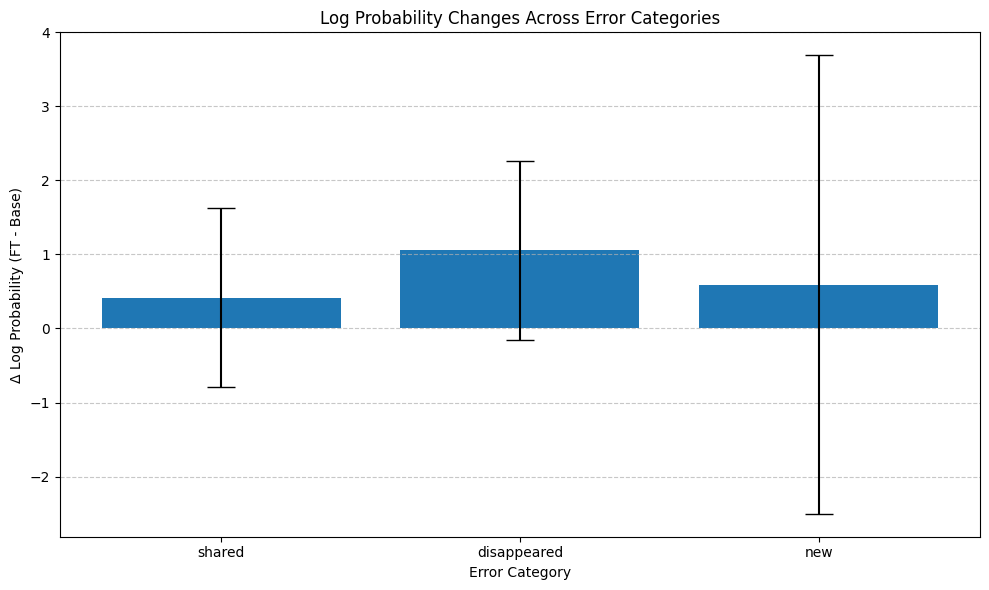

In [5]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import difflib
import nltk
from nltk.corpus import stopwords
import numpy as np

nltk.download('stopwords')

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

stop_words = set(stopwords.words('english'))
supported_formats = (".mp3", ".wav")

# Load models
base_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base.en")
base_model.eval()

model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def transcribe_model(audio_path, model, processor):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    features = processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    if hasattr(model.generation_config, "forced_decoder_ids"):
        model.generation_config.forced_decoder_ids = None

    with torch.no_grad():
        outputs = model.generate(
            input_features,
            output_scores=True,
            return_dict_in_generate=True,
        )

    predicted_ids = outputs.sequences
    transcription = processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    # Calculate log probabilities for each token
    log_probs = []
    for step, score in enumerate(outputs.scores):
        log_prob = torch.nn.functional.log_softmax(score, dim=-1)
        token_id = predicted_ids[0][step + 1]  # Skip the first token (sos)
        log_probs.append(log_prob[0, token_id].item())

    return transcription, log_probs

def get_word_alignments(ground_truth, hypothesis):
    gt_words = ground_truth.split()
    hyp_words = hypothesis.split()
    matcher = difflib.SequenceMatcher(None, gt_words, hyp_words)
    
    alignments = []
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            for i, j in zip(range(i1, i2), range(j1, j2)):
                alignments.append( (i, j, True) )
        else:
            for i in range(i1, i2):
                alignments.append( (i, None, False) )
            for j in range(j1, j2):
                alignments.append( (None, j, False) )
    return alignments

def categorize_errors(gt_words, base_words, ft_words):
    base_align = get_word_alignments(' '.join(gt_words), ' '.join(base_words))
    ft_align = get_word_alignments(' '.join(gt_words), ' '.join(ft_words))
    
    error_categories = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    for i in range(len(gt_words)):
        base_correct = any(a[0] == i and a[2] for a in base_align)
        ft_correct = any(a[0] == i and a[2] for a in ft_align)
        
        if not base_correct and not ft_correct:
            error_categories['shared'].append(i)
        elif not base_correct and ft_correct:
            error_categories['disappeared'].append(i)
        elif base_correct and not ft_correct:
            error_categories['new'].append(i)
    
    return error_categories

def calculate_deltas(error_categories, base_log_probs, ft_log_probs):
    deltas = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    # Helper to find word log probs
    def get_log_probs(word_idx, log_probs):
        if word_idx < len(log_probs):
            return log_probs[word_idx]
        return 0
    
    for idx in error_categories['shared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['shared'].append(ft_log - base_log)
    
    for idx in error_categories['disappeared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['disappeared'].append(ft_log - base_log)
    
    for idx in error_categories['new']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['new'].append(ft_log - base_log)
    
    return deltas

def transcribe_with_both_models(audio_dir):
    results = []
    error_deltas = defaultdict(list)
    
    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]
    
    for filename in tqdm(files, desc="Processing files"):
        file_path = os.path.join(audio_dir, filename)
        txt_path = os.path.join(audio_dir, os.path.splitext(filename)[0] + ".txt")
        
        with open(txt_path, 'r') as f:
            ground_truth = f.read().strip()
        
        # Transcribe with both models
        base_text, base_log_probs = transcribe_model(file_path, base_model, base_processor)
        ft_text, ft_log_probs = transcribe_model(file_path, ft_model, ft_processor)
        
        # Transform texts
        gt_processed = transforms(ground_truth)
        base_processed = transforms(base_text)
        ft_processed = transforms(ft_text)
        
        gt_words = gt_processed[0] if isinstance(gt_processed, list) else []
        base_words = base_processed[0] if isinstance(base_processed, list) else []
        ft_words = ft_processed[0] if isinstance(ft_processed, list) else []
        
        # Categorize errors
        error_cats = categorize_errors(gt_words, base_words, ft_words)
        
        # Calculate deltas
        deltas = calculate_deltas(error_cats, base_log_probs, ft_log_probs)
        
        # Aggregate deltas
        for k in deltas:
            error_deltas[k].extend(deltas[k])
        
        # Store results
        results.append({
            'filename': filename,
            'base_text': base_text,
            'ft_text': ft_text,
            'ground_truth': ground_truth,
            'errors': error_cats
        })
    
    return results, error_deltas

def analyze_deltas(error_deltas):
    analysis = {}
    for category, deltas in error_deltas.items():
        if not deltas:
            analysis[category] = {'mean': 0, 'std': 0}
            continue
        analysis[category] = {
            'mean': np.mean(deltas),
            'std': np.std(deltas),
            'count': len(deltas)
        }
    return analysis

# Run analysis
audio_dir = "dataset/c/"
results, error_deltas = transcribe_with_both_models(audio_dir)
analysis = analyze_deltas(error_deltas)

# Print results
print("\nError Category Analysis:")
for category, stats in analysis.items():
    print(f"{category.capitalize()} Errors:")
    print(f"  Count: {stats['count']}")
    print(f"  Mean Δ log-prob: {stats['mean']:.4f}")
    print(f"  Std Δ log-prob: {stats['std']:.4f}\n")

# Visualization
categories = ['shared', 'disappeared', 'new']
means = [analysis[cat]['mean'] for cat in categories]
stds = [analysis[cat]['std'] for cat in categories]

plt.figure(figsize=(10, 6))
plt.bar(categories, means, yerr=stds, capsize=10)
plt.xlabel('Error Category')
plt.ylabel('Δ Log Probability (FT - Base)')
plt.title('Log Probability Changes Across Error Categories')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('delta_log_probs.png')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing files: 100%|████████████████████████████████████████████████████████████████| 66/66 [05:57<00:00,  5.42s/it]



Error Category Analysis:
Shared Errors:
  Count: 116
  Mean Δ log-prob: 0.8771
  Std Δ log-prob: 1.7032

Disappeared Errors:
  Count: 10
  Mean Δ log-prob: 1.0793
  Std Δ log-prob: 3.0468

New Errors:
  Count: 17
  Mean Δ log-prob: 0.8283
  Std Δ log-prob: 2.1380



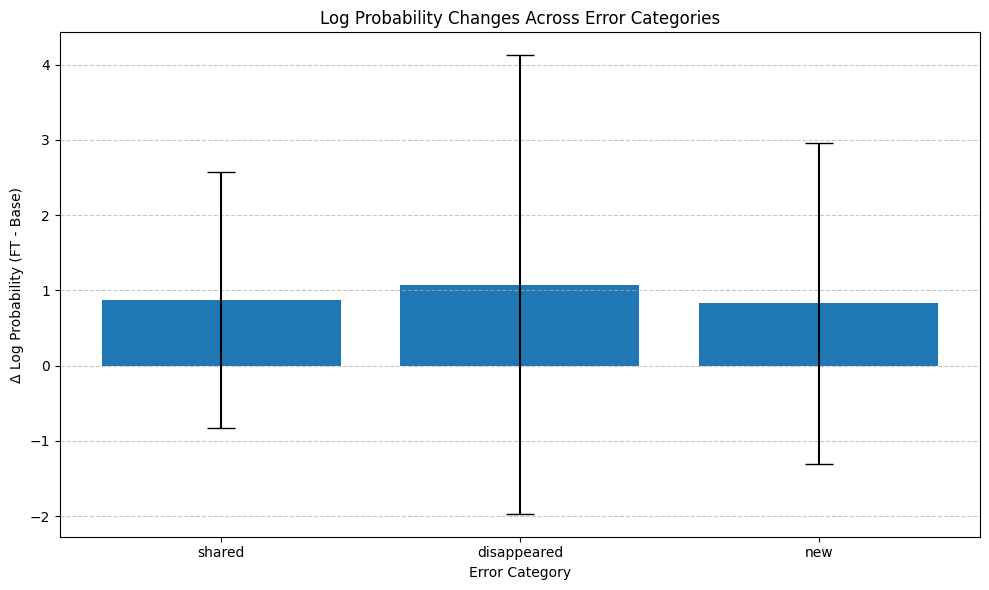

In [6]:
import whisper
import csv
import os
import warnings
from tqdm import tqdm
import jiwer
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import difflib
import nltk
from nltk.corpus import stopwords
import numpy as np

nltk.download('stopwords')

# Setup
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

transforms = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(),
])

stop_words = set(stopwords.words('english'))
supported_formats = (".mp3", ".wav")

# Load models
base_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base.en")
base_model.eval()

model_path = "C:/Users/Ashish/transcript/goodnight-moon/1st_Place/weights/oof-base.en-epoch_1/fold_0/checkpoint-1"
ft_processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
ft_model = WhisperForConditionalGeneration.from_pretrained(model_path)
ft_model.eval()

def transcribe_model(audio_path, model, processor):
    speech_array, sampling_rate = torchaudio.load(audio_path)
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech = resampler(speech_array).squeeze().numpy()

    features = processor.feature_extractor(speech, sampling_rate=16000, return_tensors="pt")
    input_features = features.input_features

    if hasattr(model.generation_config, "forced_decoder_ids"):
        model.generation_config.forced_decoder_ids = None

    with torch.no_grad():
        outputs = model.generate(
            input_features,
            output_scores=True,
            return_dict_in_generate=True,
        )

    predicted_ids = outputs.sequences
    transcription = processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    # Calculate log probabilities for each token
    log_probs = []
    for step, score in enumerate(outputs.scores):
        log_prob = torch.nn.functional.log_softmax(score, dim=-1)
        token_id = predicted_ids[0][step + 1]  # Skip the first token (sos)
        log_probs.append(log_prob[0, token_id].item())

    return transcription, log_probs

def get_word_alignments(ground_truth, hypothesis):
    gt_words = ground_truth.split()
    hyp_words = hypothesis.split()
    matcher = difflib.SequenceMatcher(None, gt_words, hyp_words)
    
    alignments = []
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            for i, j in zip(range(i1, i2), range(j1, j2)):
                alignments.append( (i, j, True) )
        else:
            for i in range(i1, i2):
                alignments.append( (i, None, False) )
            for j in range(j1, j2):
                alignments.append( (None, j, False) )
    return alignments

def categorize_errors(gt_words, base_words, ft_words):
    base_align = get_word_alignments(' '.join(gt_words), ' '.join(base_words))
    ft_align = get_word_alignments(' '.join(gt_words), ' '.join(ft_words))
    
    error_categories = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    for i in range(len(gt_words)):
        base_correct = any(a[0] == i and a[2] for a in base_align)
        ft_correct = any(a[0] == i and a[2] for a in ft_align)
        
        if not base_correct and not ft_correct:
            error_categories['shared'].append(i)
        elif not base_correct and ft_correct:
            error_categories['disappeared'].append(i)
        elif base_correct and not ft_correct:
            error_categories['new'].append(i)
    
    return error_categories

def calculate_deltas(error_categories, base_log_probs, ft_log_probs):
    deltas = {
        'shared': [],
        'disappeared': [],
        'new': []
    }
    
    # Helper to find word log probs
    def get_log_probs(word_idx, log_probs):
        if word_idx < len(log_probs):
            return log_probs[word_idx]
        return 0
    
    for idx in error_categories['shared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['shared'].append(ft_log - base_log)
    
    for idx in error_categories['disappeared']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['disappeared'].append(ft_log - base_log)
    
    for idx in error_categories['new']:
        base_log = get_log_probs(idx, base_log_probs)
        ft_log = get_log_probs(idx, ft_log_probs)
        deltas['new'].append(ft_log - base_log)
    
    return deltas

def transcribe_with_both_models(audio_dir):
    results = []
    error_deltas = defaultdict(list)
    
    files = [f for f in os.listdir(audio_dir) if f.endswith(supported_formats)]
    
    for filename in tqdm(files, desc="Processing files"):
        file_path = os.path.join(audio_dir, filename)
        txt_path = os.path.join(audio_dir, os.path.splitext(filename)[0] + ".txt")
        
        with open(txt_path, 'r') as f:
            ground_truth = f.read().strip()
        
        # Transcribe with both models
        base_text, base_log_probs = transcribe_model(file_path, base_model, base_processor)
        ft_text, ft_log_probs = transcribe_model(file_path, ft_model, ft_processor)
        
        # Transform texts
        gt_processed = transforms(ground_truth)
        base_processed = transforms(base_text)
        ft_processed = transforms(ft_text)
        
        gt_words = gt_processed[0] if isinstance(gt_processed, list) else []
        base_words = base_processed[0] if isinstance(base_processed, list) else []
        ft_words = ft_processed[0] if isinstance(ft_processed, list) else []
        
        # Categorize errors
        error_cats = categorize_errors(gt_words, base_words, ft_words)
        
        # Calculate deltas
        deltas = calculate_deltas(error_cats, base_log_probs, ft_log_probs)
        
        # Aggregate deltas
        for k in deltas:
            error_deltas[k].extend(deltas[k])
        
        # Store results
        results.append({
            'filename': filename,
            'base_text': base_text,
            'ft_text': ft_text,
            'ground_truth': ground_truth,
            'errors': error_cats
        })
    
    return results, error_deltas

def analyze_deltas(error_deltas):
    analysis = {}
    for category, deltas in error_deltas.items():
        if not deltas:
            analysis[category] = {'mean': 0, 'std': 0}
            continue
        analysis[category] = {
            'mean': np.mean(deltas),
            'std': np.std(deltas),
            'count': len(deltas)
        }
    return analysis

# Run analysis
audio_dir = "dataset/d/"
results, error_deltas = transcribe_with_both_models(audio_dir)
analysis = analyze_deltas(error_deltas)

# Print results
print("\nError Category Analysis:")
for category, stats in analysis.items():
    print(f"{category.capitalize()} Errors:")
    print(f"  Count: {stats['count']}")
    print(f"  Mean Δ log-prob: {stats['mean']:.4f}")
    print(f"  Std Δ log-prob: {stats['std']:.4f}\n")

# Visualization
categories = ['shared', 'disappeared', 'new']
means = [analysis[cat]['mean'] for cat in categories]
stds = [analysis[cat]['std'] for cat in categories]

plt.figure(figsize=(10, 6))
plt.bar(categories, means, yerr=stds, capsize=10)
plt.xlabel('Error Category')
plt.ylabel('Δ Log Probability (FT - Base)')
plt.title('Log Probability Changes Across Error Categories')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('delta_log_probs.png')
plt.show()